# Lets create a Recommendation system for the Henry coefficients of porous materials

In [95]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import scipy
import matplotlib

## We will use the Henry Coefficient matrix, created in `HenryMatrix.ipynb`

In [96]:
henry_df = pd.read_csv('data/henry_matrix_df_l_4.csv')
henry_df.set_index(list(henry_df)[0], inplace=True)
henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,RWSOTUBLDIXVET-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,LRHPLDYGYMQRHN-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,SWQJXJOGLNCZEY-UHFFFAOYSA-N_298K,GQPLMRYTRLFLPF-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K,QWTDNUCVQCZILF-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.819172,0.099828,0.319406,NaN,24.205548,37.271831,0.001506,0.036228,NaN,NaN,...,NaN,NaN,NaN,NaN,200.460054,22.948323,NaN,NaN,NaN,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,110.215565,0.539600,0.893499,0.118636,245.559959,229.944820,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000592,107.207838,177.526604,NaN
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,2.307321,0.327606,0.506284,0.206581,NaN,NaN,NaN,0.057261,11.828043,2.611847,...,NaN,10.015652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1.578894,0.225363,0.744980,0.182962,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5929.945013,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,5.248794,0.312863,0.889735,0.330443,622.896452,156.709046,53.408676,0.046230,5.584650,NaN,...,NaN,NaN,19931.415894,NaN,NaN,50.780956,NaN,NaN,NaN,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,5.390284,NaN,1.531122,NaN,NaN,NaN,30.243900,0.080570,2.688956,1.196620,...,NaN,NaN,NaN,NaN,NaN,258.624889,NaN,NaN,NaN,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,1.659813,0.217429,0.434413,NaN,NaN,NaN,1.156675,0.038380,0.915069,0.497998,...,NaN,NaN,NaN,NaN,NaN,0.735939,NaN,2.053200,NaN,NaN
NIST-MATDB-8599871cd17b08ae7919e1260a35e914,6.079439,1.311875,2.657452,NaN,NaN,NaN,NaN,0.452360,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-7c81afbf8f12d8eea290644848d46385,6.017632,1.074383,1.440551,NaN,NaN,NaN,NaN,0.215935,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
idx = np.where(henry_df.values == 0)
idx

(array([], dtype=int64), array([], dtype=int64))

In [98]:
log_henry_df = henry_df.copy()
#log_henry_df.iat[idx[0][0], idx[1][0]] = np.nan
log_henry_df = np.log(log_henry_df)
log_henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,RWSOTUBLDIXVET-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,LRHPLDYGYMQRHN-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,SWQJXJOGLNCZEY-UHFFFAOYSA-N_298K,GQPLMRYTRLFLPF-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K,QWTDNUCVQCZILF-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,-0.199462,-2.304307,-1.141293,NaN,3.186582,3.618238,-6.497979,-3.317934,NaN,NaN,...,NaN,NaN,NaN,NaN,5.300615,3.133245,NaN,NaN,NaN,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,4.702438,-0.616927,-0.112610,-2.131697,5.503541,5.437839,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.431216,4.674769,5.17912,NaN
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,0.836087,-1.115944,-0.680658,-1.577064,NaN,NaN,NaN,-2.860130,2.470473,0.960058,...,NaN,2.304149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,0.456725,-1.490043,-0.294398,-1.698475,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.687770,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1.657998,-1.161989,-0.116832,-1.107322,6.434380,5.054391,3.977973,-3.074125,1.720022,NaN,...,NaN,NaN,9.900052,NaN,NaN,3.927521,NaN,NaN,NaN,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,1.684598,NaN,0.426001,NaN,NaN,NaN,3.409294,-2.518626,0.989153,0.179501,...,NaN,NaN,NaN,NaN,NaN,5.555379,NaN,NaN,NaN,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,0.506705,-1.525884,-0.833758,NaN,NaN,NaN,0.145550,-3.260207,-0.088756,-0.697158,...,NaN,NaN,NaN,NaN,NaN,-0.306609,NaN,0.719400,NaN,NaN
NIST-MATDB-8599871cd17b08ae7919e1260a35e914,1.804912,0.271457,0.977368,NaN,NaN,NaN,NaN,-0.793277,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-7c81afbf8f12d8eea290644848d46385,1.794694,0.071746,0.365026,NaN,NaN,NaN,NaN,-1.532778,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
log_henry_df.shape

(192, 39)

In [100]:
sigmoid_henry_df = henry_df.copy()
sigmoid_henry_df = np.tanh(sigmoid_henry_df)
sigmoid_henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,RWSOTUBLDIXVET-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,LRHPLDYGYMQRHN-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,SWQJXJOGLNCZEY-UHFFFAOYSA-N_298K,GQPLMRYTRLFLPF-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K,QWTDNUCVQCZILF-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.674619,0.099498,0.308969,NaN,1.0,1.0,0.001506,0.036212,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,NaN,NaN,NaN,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1.000000,0.492685,0.713118,0.118082,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000592,1.0000,1.0,NaN
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,0.980383,0.316368,0.467045,0.203691,NaN,NaN,NaN,0.057199,1.000000,0.989283,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,0.918429,0.221624,0.632145,0.180948,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,0.999945,0.303040,0.711263,0.318918,1.0,1.0,1.000000,0.046197,0.999972,NaN,...,NaN,NaN,1.0,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,0.999958,NaN,0.910616,NaN,NaN,NaN,1.000000,0.080396,0.990808,0.832621,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,0.930192,0.214066,0.409003,NaN,NaN,NaN,0.819953,0.038362,0.723556,0.460542,...,NaN,NaN,NaN,NaN,NaN,0.626685,NaN,0.9676,NaN,NaN
NIST-MATDB-8599871cd17b08ae7919e1260a35e914,0.999990,0.864749,0.990213,NaN,NaN,NaN,NaN,0.423837,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-7c81afbf8f12d8eea290644848d46385,0.999988,0.791107,0.893809,NaN,NaN,NaN,NaN,0.212640,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
#Creates a dictionary of InChIKeys to gas names (and gas names to InChIKeys)
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names (and material names to hashkeys)
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

## Lets also define a function that will randomly split our data into <i>k</i> folds

In [226]:
def k_fold_split(henry_df, k, max_iter=1000):
    assert k > 1, 'Choose a `k` greater than 1, otherwise this function is pointless'
    matrix = henry_df.values
    fold_matrix = np.full_like(matrix, -1, dtype=np.int)
    all_k_folds_not_represented_in_each_column = True
    n_iteration = 0
    while all_k_folds_not_represented_in_each_column:
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = False
        for i_row in range(matrix.shape[0]):
            # Grabs all available indices in row `i_row`
            j_indices = np.where(~np.isnan(matrix[i_row,:]))[0]
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while len(j_indices) >= k:
                for fold in range(k):
                    j = np.random.randint(0, len(j_indices))
                    fold_matrix[i_row, j_indices[j]] = fold
                    j_indices = np.delete(j_indices, j)
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for j in j_indices:
                fold_matrix[i_row, j] = np.random.randint(0, k)
        # We make sure we have enough data points in the columns as well
        for j_col in range(matrix.shape[1]):
            unique_folds = np.unique(fold_matrix[:, j_col])
            #print(len(vals[~np.isnan(vals)]))
            if len(unique_folds) <= k:
                all_k_folds_not_represented_in_each_column = True
                break
        # If too many iteration are performed an Exception is raised.
        if n_iteration > max_iter:
            raise Exception('Maximum number of iterations reached. Try changing the `max_iter` argument.')
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if np.isnan(matrix[i,j]):
                continue
            else:
                a
    
    print('Number of iterations required to split data into {}-folds: {}'.format(k, n_iteration))
    for fold in range(k):
        print('Number of data points in fold {:d}: {:d}'.format(fold, np.sum(fold_matrix == fold)))
    print('Total number of data points: {:d}'.format(np.sum(~np.isnan(henry_df.values))))
    print('-----------------------------------')
    return fold_matrix

fold_matrix = k_fold_split(henry_df, 3, max_iter=1e5)


Number of iterations required to split data into 3-folds: 321
Number of data points in fold 0: 375
Number of data points in fold 1: 352
Number of data points in fold 2: 357
Total number of data points: 1084
-----------------------------------


In [103]:
def sort_matrix_by_freq(material_gas_matrix):
    row_sum = np.sum(material_gas_matrix, axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(material_gas_matrix[new_row_order, :], axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return material_gas_matrix[new_row_order, :][:, new_col_order]

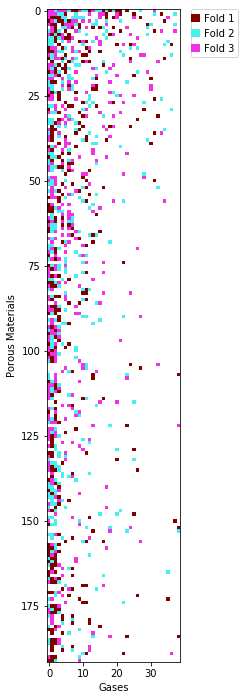

In [104]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
#my_cmap = matplotlib.cm.get_cmap('Accent')
mycmap = matplotlib.colors.ListedColormap(np.array([[255/255, 255/255, 255/255, 1], 
                                                    [128/255, 0, 0, 1], 
                                                    [70/255, 240/255, 240/255, 1], 
                                                    [240/255, 50/255, 230/255, 1],
                                                    [60/255, 180/255, 75/255, 1],
                                                    [245/255, 130/255, 48/255, 1]][:len(np.unique(fold_matrix))]))
plt.imshow(sort_matrix_by_freq(fold_matrix), interpolation='none', cmap=mycmap)
custom_points = [matplotlib.lines.Line2D([0], [0], color=mycmap(1), lw=8),
                 matplotlib.lines.Line2D([0], [0], color=mycmap(2), lw=8),
                 matplotlib.lines.Line2D([0], [0], color=mycmap(3), lw=8)]
plt.legend(custom_points, ['Fold 1', 'Fold 2', 'Fold 3'], handlelength=0.1,
           bbox_to_anchor=(1.44,1), borderaxespad=0)
ax.set_xlabel('Gases')
ax.set_ylabel('Porous Materials')
#cbar = plt.colorbar()
#cbar.set_label('Fold', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')
plt.savefig('pics/foldmatrix.png', format='png', dpi=300)
plt.show()

### Lets start setting up the Recommender System algorithm

#### ALS methods implemented according to http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

M shape: (1, 192)	G shape: (1, 39)
Train Error on iteration 0: 3.531355181938754
-------------
Train Error on iteration 1000: 1.0060935498611443
-------------
Training has converged after 1967 iterations. See `convergence` parameter for convergence procedure.
Train error: 1.0073497370210722


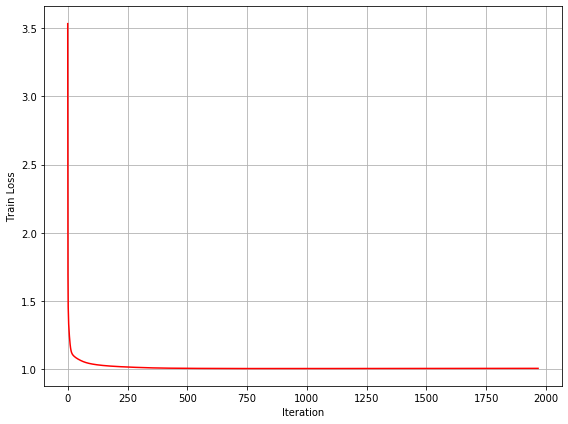

In [219]:
def ALSv2(henry_matrix, r, lambd, threshold, convergence=1e-6, maxiter=20000, verbose=True):
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    convergence_cnt = 0
    nm = henry_matrix.shape[0]
    ng = henry_matrix.shape[1]
        
    M = np.random.rand(r, nm)-0.5
    G = np.random.rand(r, ng)-0.5
    mof_bias = np.zeros((1, nm))
    gas_bias = np.zeros((1, ng))
    mu = np.nanmean(henry_matrix)
    Im = lambd[0]/nm * np.identity(r)
    Ig = lambd[1]/ng * np.identity(r)
    
    if verbose:
        print('M shape: {}\tG shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        for m in range(M.shape[1]):
            gases_in_which_H_of_this_mof_is_measured = ~np.isnan(henry_matrix[m,:])
            biased_H = henry_matrix[m, gases_in_which_H_of_this_mof_is_measured] -\
                (mu + gas_bias[0, gases_in_which_H_of_this_mof_is_measured] + mof_bias[0, m])
            b = (G[:, gases_in_which_H_of_this_mof_is_measured]).dot(biased_H.T)
            A = G[:, gases_in_which_H_of_this_mof_is_measured].dot(G[:, gases_in_which_H_of_this_mof_is_measured].T) + Im
            M[:,m] = np.linalg.solve(A,b)
            mof_bias[0, m] = (np.sum([henry_matrix[m, g] - gas_bias[0, g] - mu - M[:,m].T.dot(G[:,g])\
                                     for g in np.arange(ng)[gases_in_which_H_of_this_mof_is_measured]]))\
                                        /(np.sum(gases_in_which_H_of_this_mof_is_measured) + lambd[0]/nm)
        for g in range(G.shape[1]):
            mofs_in_which_H_of_this_gas_is_measured = ~np.isnan(henry_matrix[:,g])
            biased_H = henry_matrix[mofs_in_which_H_of_this_gas_is_measured, g] -\
                (mu + mof_bias[0, mofs_in_which_H_of_this_gas_is_measured] + gas_bias[0, g])
            b = M[:,mofs_in_which_H_of_this_gas_is_measured].dot(biased_H)
            A = M[:,mofs_in_which_H_of_this_gas_is_measured].dot(M[:,mofs_in_which_H_of_this_gas_is_measured].T) + Ig
            G[:,g] = np.linalg.solve(A,b)
            gas_bias[0, g] = (np.sum([henry_matrix[m, g] - mof_bias[0, m] - mu - M[:,m].T.dot(G[:,g])\
                                     for m in np.arange(nm)[mofs_in_which_H_of_this_gas_is_measured]]))\
                                    /(np.sum(mofs_in_which_H_of_this_gas_is_measured) + lambd[1]/ng)
            
        #pred = predict_all(M, G, 0.0)[~np.isnan(henry_matrix)]
        pred = (M.T.dot(G) + mu + mof_bias.T + gas_bias)[~np.isnan(henry_matrix)]
        actual = henry_matrix[~np.isnan(henry_matrix)]
        prev_error = train_error
        train_error = np.sum([(actual - pred)**2])/len(pred)
        train_error_arr.append(train_error)
        error_diff = np.abs(prev_error - train_error)
        if n % 1000 == 0:
            if verbose:
                print('Train Error on iteration {}: {}\n-------------'.format(n, train_error))
            
        if error_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 199:
                if verbose:
                    print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                    print('Train error: {}'.format(train_error))
                break
        else:
            convergence_cnt = 0
        n += 1
        if n > maxiter:
            print('Maximum number of iterations ({}) reached.'.format(maxiter))
            break
        if np.count_nonzero(np.isnan(M)) > 0 or np.count_nonzero(np.isnan(G)) > 0:
            raise Exception('NaN encountered in either latent representation')
    
    if verbose:
        fig, ax = plt.subplots(figsize=(8,6))
        #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Train Loss')
        plt.grid('on')
        plt.tight_layout()
        plt.show()
    
    return M, G, mof_bias, gas_bias, train_error_arr[-1]
m, g, mb, gb, err = ALSv2(log_henry_df.values, 1, [100.1, 0.1], 1e-5, maxiter=10000)

M shape: (2, 192)	G shape: (2, 39)
Train Error on iteration 0: 2.5044048178301437
-------------
Train Error on iteration 1000: 0.5195387704178702
-------------
Train Error on iteration 2000: 0.4978917311376781
-------------
Train Error on iteration 3000: 0.49595173048745195
-------------
Train Error on iteration 4000: 0.49477438971805476
-------------
Training has converged after 4014 iterations. See `convergence` parameter for convergence procedure.
Train error: 0.494761646428729


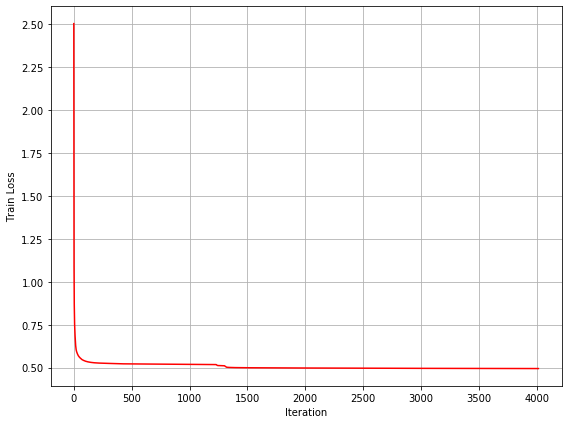

In [106]:
def ALS(henry_matrix, r, lambd, threshold, convergence=1e-6, maxiter=20000, verbose=True):
    assert len(lambd) == 2, "There should be two lambda values, one for each latent matrix"
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    convergence_cnt = 0
        
    M = np.random.rand(r, henry_matrix.shape[0])-0.5
    G = np.random.rand(r, henry_matrix.shape[1])-0.5
    mof_bias = np.zeros((1, henry_matrix.shape[0]))
    gas_bias = np.zeros((1, henry_matrix.shape[1]))
    I1 = lambd[0]/henry_matrix.shape[0] * np.identity(r+1)
    I2 = lambd[1]/henry_matrix.shape[1] * np.identity(r+1)
    
    if verbose:
        print('M shape: {}\tG shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        Gbar = np.vstack((np.ones((G.shape[1])), G))
        for m in range(M.shape[1]):
            gases_in_which_H_of_this_mof_is_measured = ~np.isnan(henry_matrix[m,:])
            biased_H = henry_matrix[m, gases_in_which_H_of_this_mof_is_measured] - gas_bias[0, gases_in_which_H_of_this_mof_is_measured]
            b = (Gbar[:, gases_in_which_H_of_this_mof_is_measured]).dot(biased_H.T)
            A = Gbar[:, gases_in_which_H_of_this_mof_is_measured].dot(Gbar[:, gases_in_which_H_of_this_mof_is_measured].T) + I1
            sol = np.linalg.solve(A,b)
            M[:,m] = sol[1:]
            mof_bias[0, m] = sol[0]
            #M[-2,m] = 1.0
        Mbar = np.vstack((np.ones(M.shape[1]), M))
        for g in range(G.shape[1]):
            mofs_in_which_H_of_this_gas_is_measured = ~np.isnan(henry_matrix[:,g])
            biased_H = henry_matrix[mofs_in_which_H_of_this_gas_is_measured, g] - mof_bias[0, mofs_in_which_H_of_this_gas_is_measured]
            b = Mbar[:,mofs_in_which_H_of_this_gas_is_measured].dot(biased_H)
            A = Mbar[:,mofs_in_which_H_of_this_gas_is_measured].dot(Mbar[:,mofs_in_which_H_of_this_gas_is_measured].T) + I2
            sol = np.linalg.solve(A,b)
            G[:,g] = sol[1:]
            gas_bias[0, g] = sol[0]
            #G[-1,g] = 1.0
            
        #pred = predict_all(M, G, 0.0)[~np.isnan(henry_matrix)]
        pred = (M.T.dot(G) + mof_bias.T + gas_bias)[~np.isnan(henry_matrix)]
        actual = henry_matrix[~np.isnan(henry_matrix)]
        prev_error = train_error
        train_error = np.sum([(actual - pred)**2])/len(pred)
        train_error_arr.append(train_error)
        error_diff = np.abs(prev_error - train_error)
        if n % 1000 == 0:
            if verbose:
                print('Train Error on iteration {}: {}\n-------------'.format(n, train_error))
            
        if error_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 199:
                if verbose:
                    print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                    print('Train error: {}'.format(train_error))
                break
        else:
            convergence_cnt = 0
        n += 1
        if n > maxiter:
            print('Maximum number of iterations ({}) reached.'.format(maxiter))
            break
        if np.count_nonzero(np.isnan(M)) > 0 or np.count_nonzero(np.isnan(G)) > 0:
            raise Exception('NaN encountered in either latent representation')
    
    if verbose:
        fig, ax = plt.subplots(figsize=(8,6))
        #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Train Loss')
        plt.grid('on')
        plt.tight_layout()
        plt.show()
    
    return M, G, mof_bias, gas_bias, train_error_arr[-1]
m, g, mb, gb, err = ALS(log_henry_df.values, 2, [1.1, 0.2], 1e-5, maxiter=10000)

In [220]:
def cross_validation(henry_df, fold_matrix, r, lambd1, lambd2):
    k = len(np.unique(fold_matrix))-1
    print('-----------------------------------------\nStarting ALS with the following parameters:\nr = {}, lambda = [{:.2f}, {:.2f}]'.format(r, lambd1, lambd2))
    test_errors = []
    parity_pred = np.full(henry_df.shape, np.nan)
    
    for test_fold in range(k):
        M, G, Mbias, Gbias, train_error = ALSv2(henry_df.mask(fold_matrix == test_fold).values, r, [lambd1, lambd2], 1e-6, 1e-7, 50000, False)
        pred = (M.T.dot(G) + Mbias.T + Gbias)[fold_matrix == test_fold]
        parity_pred[fold_matrix == test_fold] = pred
        actual = henry_df.values[fold_matrix == test_fold]
        test_errors.append(np.sum([(actual - pred)**2])/len(actual))
        #print(train_error)
        #print(test_errors[test_fold])
        #print(actual)
    test_error = np.mean(test_errors)
    print('Test Error: {:.3f}'.format(test_error))
    return test_error, Mbias, Gbias, parity_pred

_r = [1, 2, 3]
_lambd1 = np.logspace(1, 4, num=4)
_lambd2 = np.logspace(1, 4, num=4)
_lambd = np.logspace(1.0, 5.0, num=50)
fold_matrix = k_fold_split(log_henry_df, 3, max_iter=10000)
CV_dict = {}
gas_mean_parity_pred = np.zeros(log_henry_df.shape)
mof_mean_parity_pred = np.zeros(log_henry_df.shape)

mu = np.nanmean(log_henry_df.values)

for r in _r:
    for lambd1 in _lambd1:
        for lambd2 in _lambd2:
            for test_fold in range(3):
                train_mean_gas = np.mean(log_henry_df.mask(fold_matrix == test_fold), axis=0)
                train_mean_material = np.mean(log_henry_df.mask(fold_matrix == test_fold), axis=1)
                for row in range(log_henry_df.shape[0]):
                    for col in range(log_henry_df.shape[1]):
                        if fold_matrix[row,col] == test_fold:
                            gas_mean_parity_pred[row,col] = train_mean_gas[col]
                            mof_mean_parity_pred[row,col] = train_mean_material[row]
            test_error, Mbias, Gbias, parity_pred = cross_validation(log_henry_df, fold_matrix, r, lambd1, lambd2)
            cv_key = '{}_{}_{}'.format(r, lambd1, lambd2)
            CV_dict['{}_err'.format(cv_key)] = test_error
            CV_dict['{}_pred'.format(cv_key)] = parity_pred
            CV_dict['{}_mbias'.format(cv_key)] = Mbias
            CV_dict['{}_gbias'.format(cv_key)] = Gbias
            CV_dict['{}_r'.format(cv_key)] = r
            CV_dict['{}_lambda1'.format(cv_key)] = lambd1
            CV_dict['{}_lambda2'.format(cv_key)] = lambd2
      

Number of iterations required to split data into 3-folds: 2630
-----------------------------------------
Starting ALS with the following parameters:
r = 1, lambda = [100.00, 100.00]
Test Error: 7.565
-----------------------------------------
Starting ALS with the following parameters:
r = 1, lambda = [100.00, 2154.43]
Test Error: 6.764
-----------------------------------------
Starting ALS with the following parameters:
r = 1, lambda = [100.00, 46415.89]
Test Error: 11.295
-----------------------------------------
Starting ALS with the following parameters:
r = 1, lambda = [100.00, 1000000.00]
Test Error: 12.821
-----------------------------------------
Starting ALS with the following parameters:
r = 1, lambda = [2154.43, 100.00]
Test Error: 6.716
-----------------------------------------
Starting ALS with the following parameters:
r = 1, lambda = [2154.43, 2154.43]
Test Error: 9.759
-----------------------------------------
Starting ALS with the following parameters:
r = 1, lambda = [

In [221]:
min_err = np.inf
min_key = "asdf"
for key in CV_dict:
    if key.split('_')[-1] != 'err':
        continue
    if type(CV_dict[key]) != np.float64:
        continue
    if CV_dict[key] < min_err:
        min_err = CV_dict[key]
        min_key = key
        
min_key

'2_2154.4346900318824_100.0_err'

In [222]:
parity_pred = CV_dict['_'.join(min_key.split('_')[:-1]) + '_pred']
Mbias = CV_dict['_'.join(min_key.split('_')[:-1]) + '_mbias']
Gbias = CV_dict['_'.join(min_key.split('_')[:-1]) + '_gbias']
r = CV_dict['_'.join(min_key.split('_')[:-1]) + '_r']
lambda1 = CV_dict['_'.join(min_key.split('_')[:-1]) + '_lambda1']
lambda2 = CV_dict['_'.join(min_key.split('_')[:-1]) + '_lambda2']

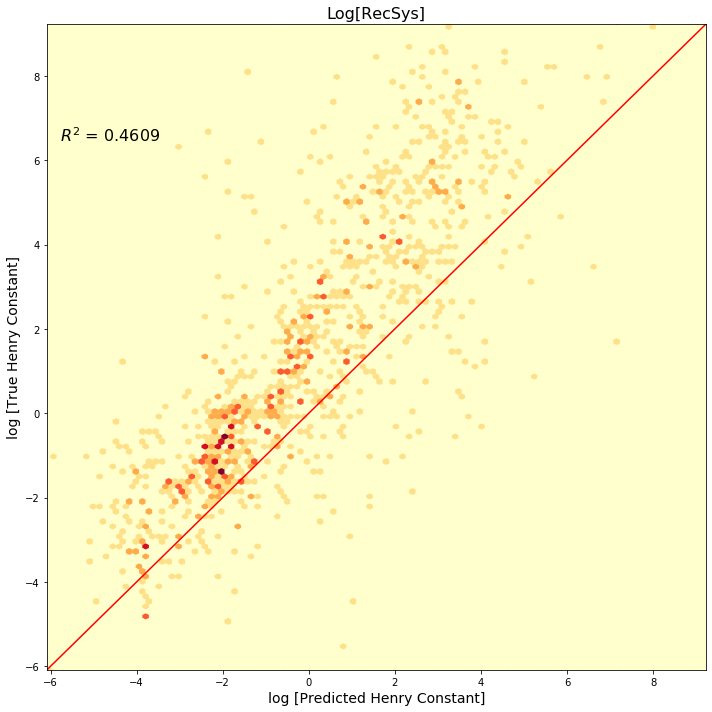

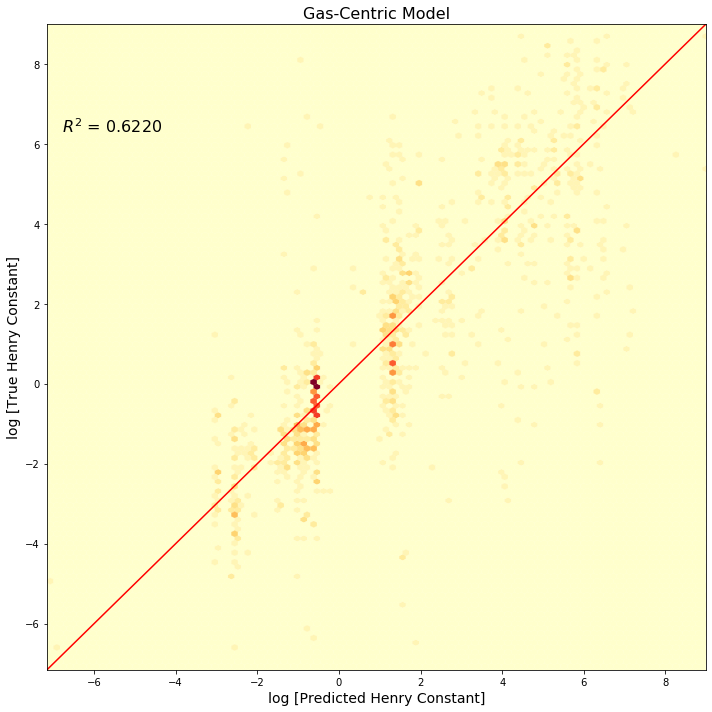

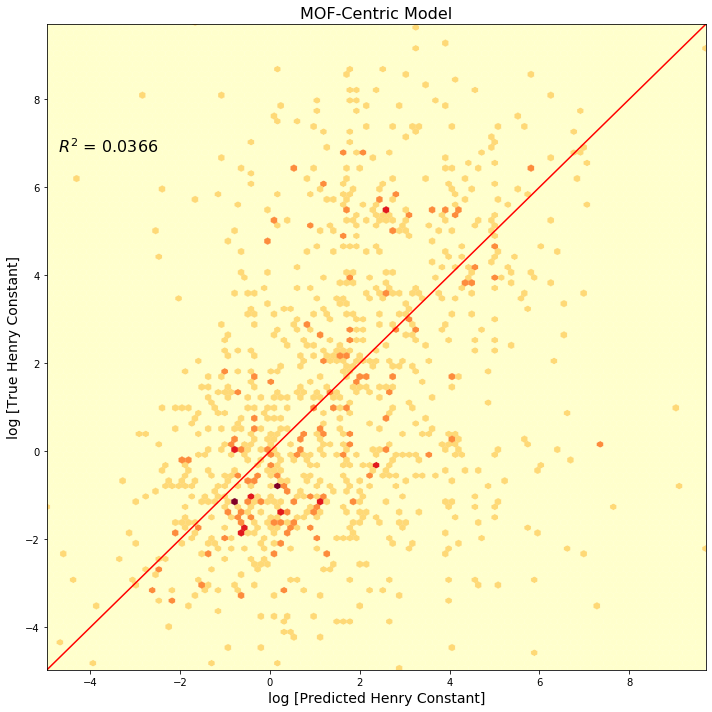

In [223]:
def parity_plot(actual, parity_pred, title):
    fig, ax = plt.subplots(figsize=(10,10))
    
    prediction = parity_pred.flatten()
    actual = actual.values.flatten()
    mask = ~np.isnan(actual)
    
    test_mean = np.nanmean(actual)
    R_squared = 1 - (np.sum([(actual[i] - prediction[i])**2 for i in np.arange(len(actual))[mask]]) / np.sum([(actual[i] - test_mean)**2 for i in np.arange(len(actual))[mask]]))
    ax.hexbin(prediction[mask], actual[mask], gridsize=(100,100), cmap='YlOrRd', linewidth=0.25)
    #ax.scatter(prediction[mask], actual[mask])
    #lim = [-10, 10]
    
    lim = [np.max([np.min(actual[mask]), np.min(prediction[mask])]), np.min([np.max(actual[mask]), np.max(prediction[mask])])]
    
    ax.plot(lim, lim, c='r')
    ax.set_xlabel('log [Predicted Henry Constant]', fontsize=14)
    ax.set_ylabel('log [True Henry Constant]', fontsize=14)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.text(lim[0]*0.95, lim[1]*0.7, '$R^2$ = {:.4f}'.format(R_squared), fontsize=16)
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.savefig('pics/' + title + '.png', format='png', dpi=300)
    
    plt.show()
    
parity_plot(log_henry_df, parity_pred, 'Log[RecSys]')
parity_plot(log_henry_df, gas_mean_parity_pred, 'Gas-Centric Model')
parity_plot(log_henry_df, mof_mean_parity_pred, 'MOF-Centric Model')

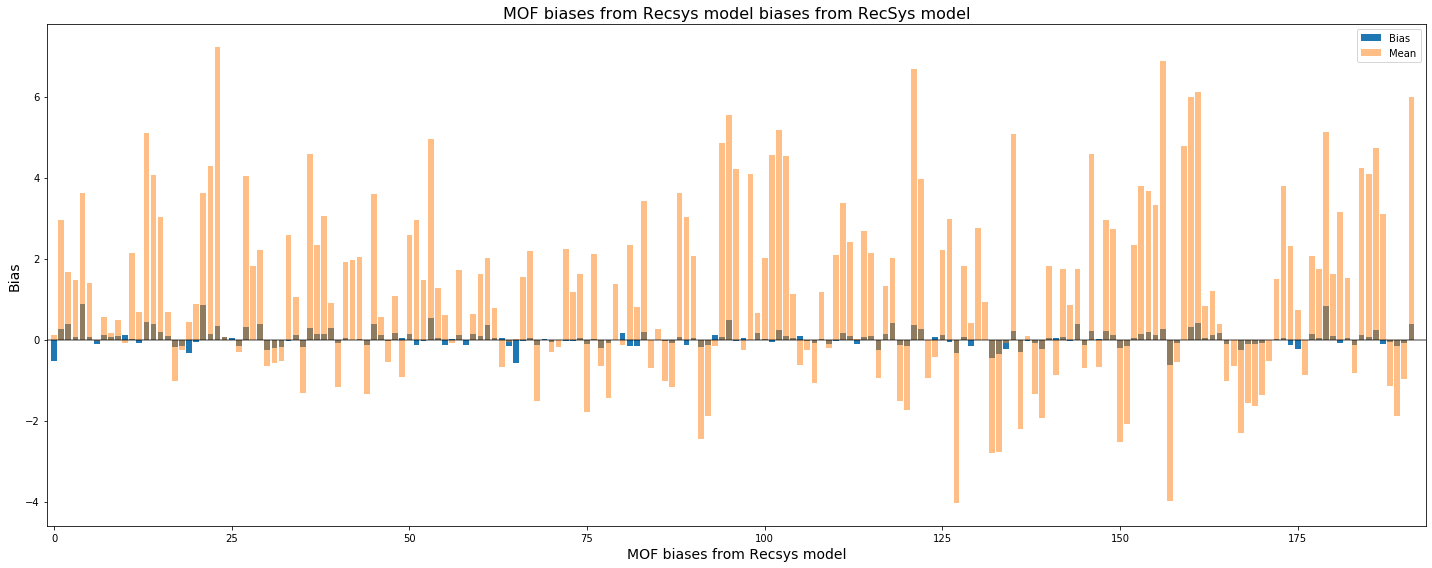

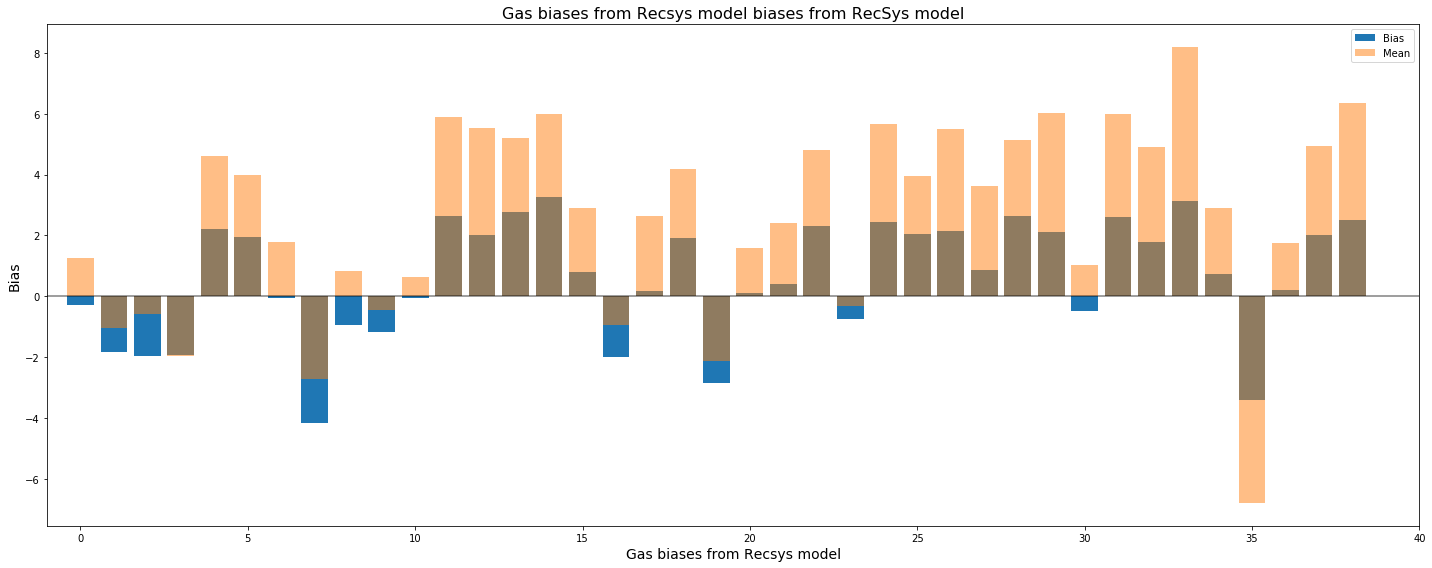

In [224]:
def plot_biases(bias, means, mof_or_gas):
    fig, ax = plt.subplots(figsize=(20,8))
    
    N = len(bias[0,:])
    #ax.bar(np.arange(N), bias[0,:], width=0.45, label='Bias')
    #ax.bar(np.arange(N)+0.45, means-np.mean(means), width=0.45, label='Mean')
    ax.bar(np.arange(N), bias[0,:], label='Bias')
    ax.bar(np.arange(N), means, alpha=0.5, label='Mean')
    xlim = ax.get_xlim()
    ax.plot(xlim, [0,0], c='k', lw=1.5, alpha=0.5)
    ax.set_xlim(-1, N+1)
    ax.set_xlabel(mof_or_gas, fontsize=14)
    ax.set_ylabel('Bias', fontsize=14)
    ax.set_title(mof_or_gas + ' biases from RecSys model', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.savefig('pics/' + mof_or_gas + '_biases_plot.png', format='png', dpi=300)
    plt.show()
plot_biases(Mbias, np.nanmean(log_henry_df.values, axis=1), 'MOF biases from Recsys model')
plot_biases(Gbias, np.nanmean(log_henry_df.values, axis=0), 'Gas biases from Recsys model')

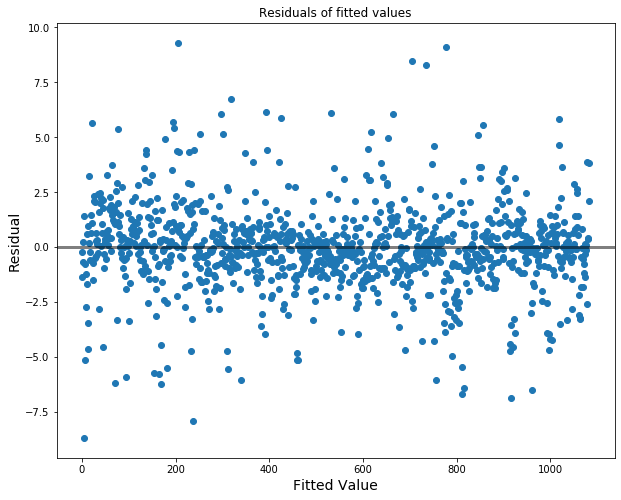

In [197]:
fig, ax = plt.subplots(figsize=(10,8))
mask = ~np.isnan(log_henry_df.values.flatten())
residuals = log_henry_df.values.flatten()[mask] - parity_pred.flatten()[mask]
ax.scatter(np.arange(len(residuals)), residuals)
lim = ax.get_xlim()
ax.plot([-100, 2*lim[1]], [0,0], color='k', linewidth=3, alpha=0.5)
ax.set_xlim(lim)
ax.set_xlabel('Fitted Value', fontsize=14)
ax.set_ylabel('Residual', fontsize=14)
ax.set_title('Residuals of fitted values')
plt.show()

In [202]:
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

In [218]:
def find_best_gas_separator(henry_df, r, lambda1, lambda2, gas1, gas2, maxnumber=15):
    assert gas1 + '_298K' in henry_df.columns and gas2 + '_298K' in henry_df.columns
    
    M, G, Mbias, Gbias, train_error = ALSv2(henry_df.values, r, [lambda1, lambda2], 1e-6, 1e-7, 50000, False)
    H = M.T.dot(G)
    gas_index1 = np.where(henry_df.columns == gas1 + '_298K')[0][0]
    gas_index2 = np.where(henry_df.columns == gas2 + '_298K')[0][0]
    
    Nm = len(henry_df.index)
    selectivities = np.zeros(Nm)
    
    for i in range(Nm):
        selectivities[i] = np.exp(H[i, gas_index1]) / np.exp(H[i, gas_index2])
    sorted_indices = np.argsort(selectivities)
    
    print('Best Materials to separate {:s} and {:s}\n'.format(key_to_gas[gas1], key_to_gas[gas2]))
    for (i, index) in enumerate(sorted_indices[::-1]):
        if i > maxnumber:
            break
        print('#{:d}: {:40s}\t {:s}/{:s} = {:.3f}\n'.format(i+1, key_to_material[henry_df.index[index]], 
                                                          key_to_gas[gas1], key_to_gas[gas2], selectivities[index]))
    return
find_best_gas_separator(log_henry_df, r, lambda1, lambda2, gas_to_key['Krypton'], gas_to_key['Xenon'])

Best Materials to separate Krypton and Xenon

#1: ZIF-8                                   	 Krypton/Xenon = 1.198

#2: [Co3(ndc)-(HCOO)3(mu3-OH)(H2O)]n        	 Krypton/Xenon = 1.193

#3: NU-135                                  	 Krypton/Xenon = 1.130

#4: C62H50Cd3K2N2O26                        	 Krypton/Xenon = 1.120

#5: IRMOF-1                                 	 Krypton/Xenon = 1.118

#6: {[Cu2(4-pmpmd)2(CH3OH)4(opd)2]*2H2O}    	 Krypton/Xenon = 1.114

#7: MIL-47                                  	 Krypton/Xenon = 1.106

#8: MOF-74-Ni                               	 Krypton/Xenon = 1.105

#9: eea-MOF-4                               	 Krypton/Xenon = 1.100

#10: MOF-2                                   	 Krypton/Xenon = 1.099

#11: eea-MOF-5                               	 Krypton/Xenon = 1.099

#12: ZSM-5                                   	 Krypton/Xenon = 1.098

#13: MOF-74-Co                               	 Krypton/Xenon = 1.085

#14: Zn(II)-MOF [Zn(HPylmDC)(DMA)]n          	 Krypto

In [157]:
def sort_df_by_freq(df):
    row_sum = np.sum(~np.isnan(df.values), axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(~np.isnan(df.values[new_row_order, :]), axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return new_row_order, new_col_order
new_row_order, new_col_order = sort_df_by_freq(log_henry_df)

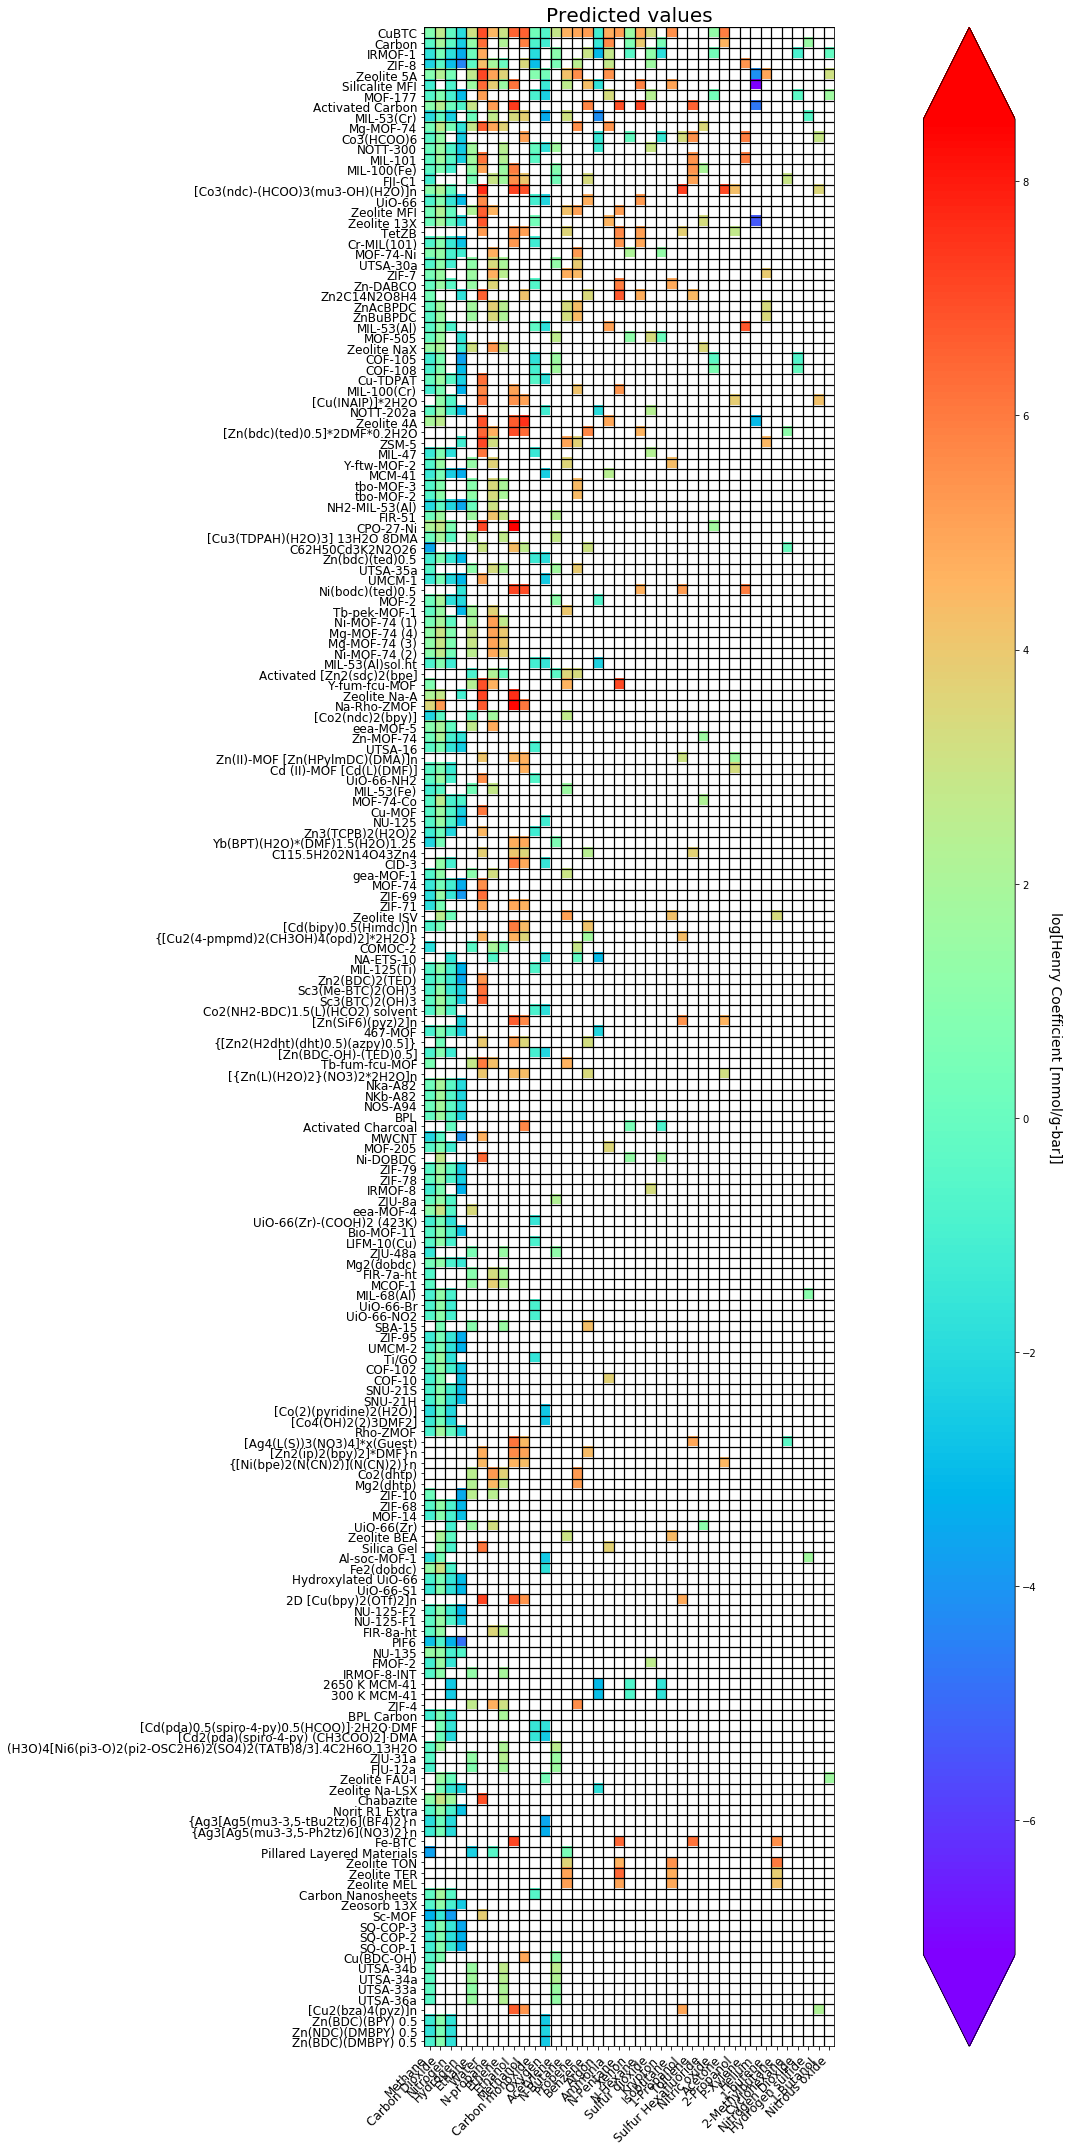

In [174]:
fig = plt.figure(figsize=(25,30))
ax = plt.gca()
temp_h = np.copy(parity_pred)

new_row_order, new_col_order = sort_df_by_freq(pd.DataFrame(temp_h))

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(temp_h[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.Normalize())
cbar = plt.colorbar(extend='both')
cbar.set_label('log[Henry Coefficient [mmol/g-bar]]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(parity_pred.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(parity_pred.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)
plt.title('Predicted values', fontsize=20)
plt.tight_layout()
plt.savefig('pics/CoolPic.png', dpi=300, format='png')

plt.show()

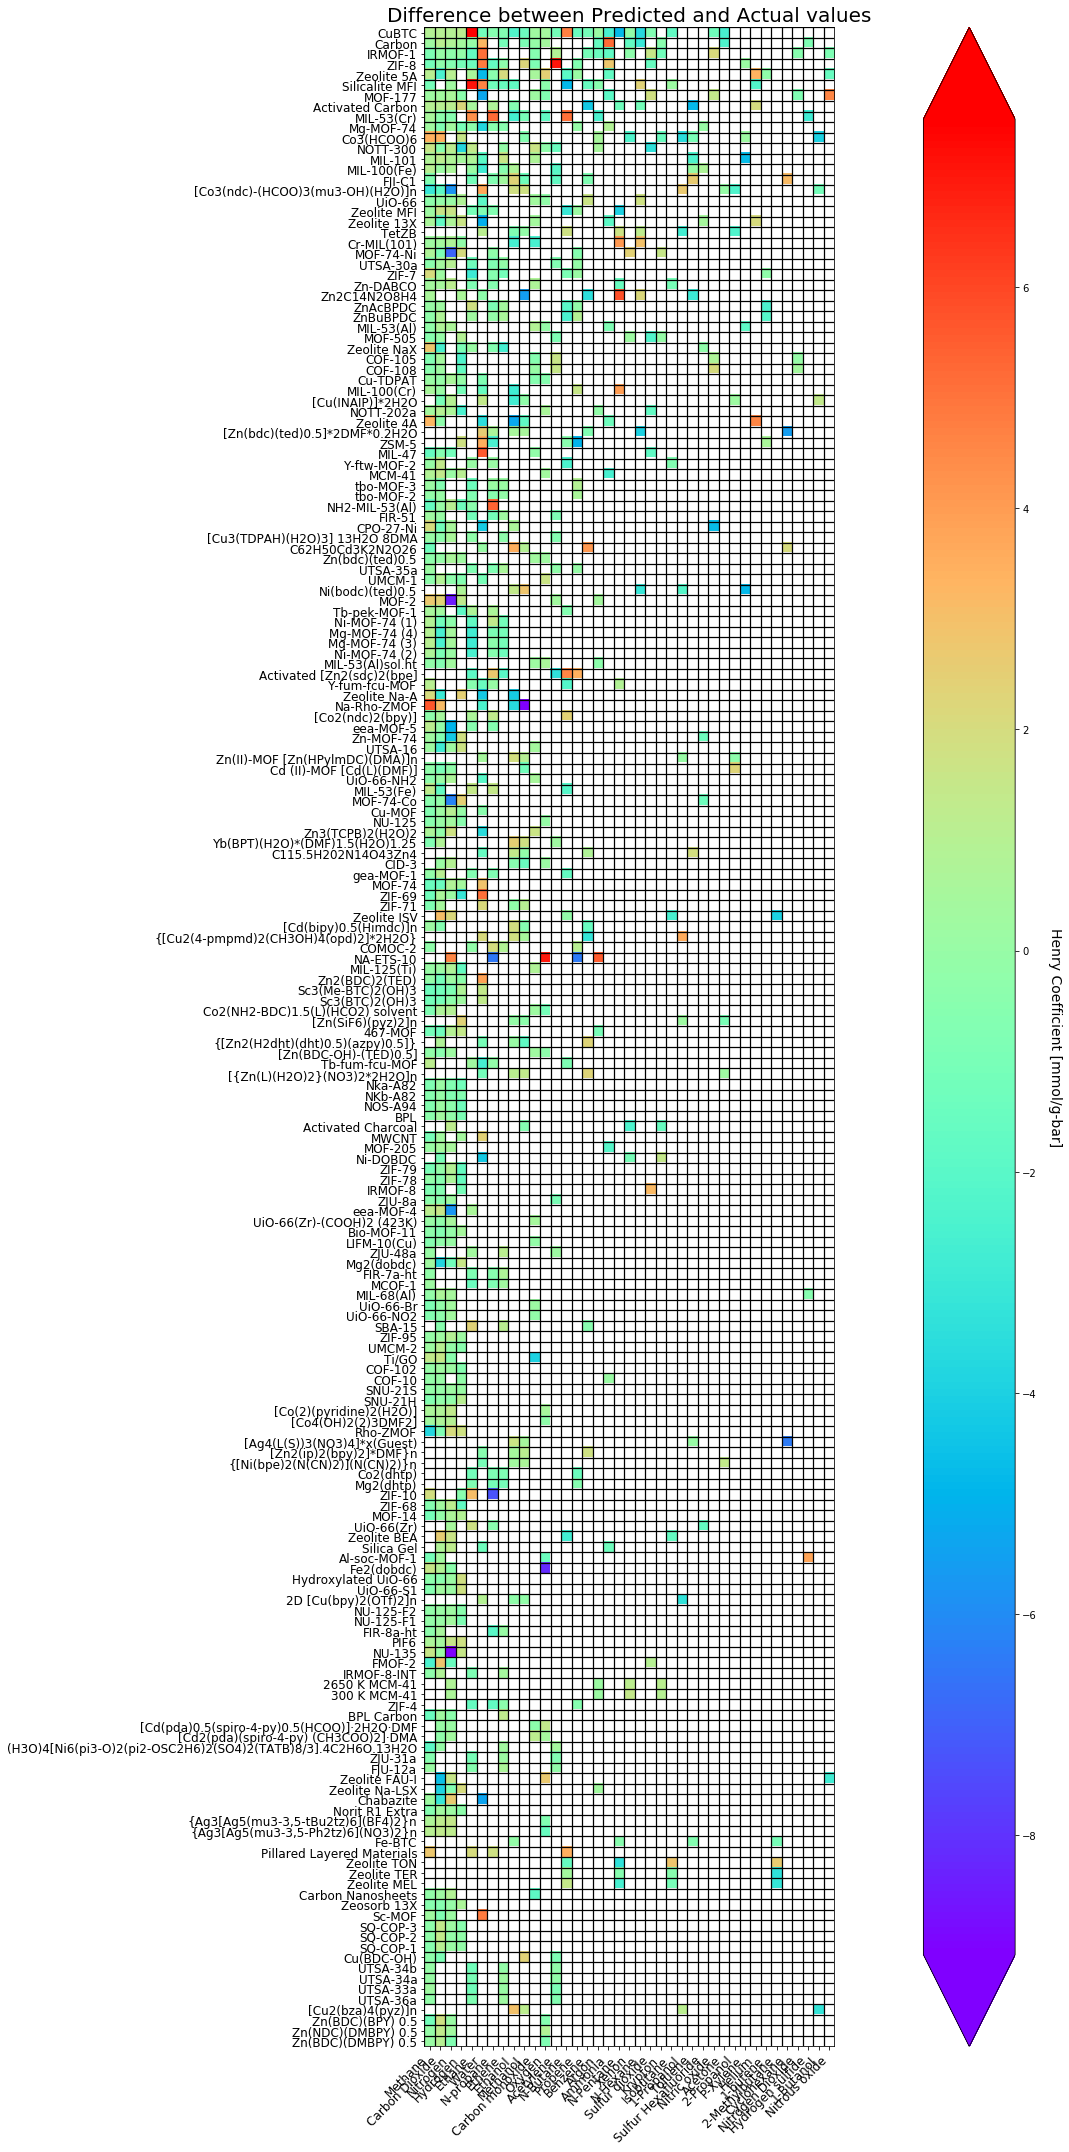

In [175]:
fig = plt.figure(figsize=(25,30))
ax = plt.gca()
h_diff = np.clip(parity_pred - log_henry_df.values, -1e4, 1e6)

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(h_diff[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow')
cbar = plt.colorbar(extend='both')
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(parity_pred.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(parity_pred.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)
plt.title('Difference between Predicted and Actual values', fontsize=20)
plt.tight_layout()
plt.savefig('pics/another_coolpic.png', format='png', dpi=300)

plt.show()

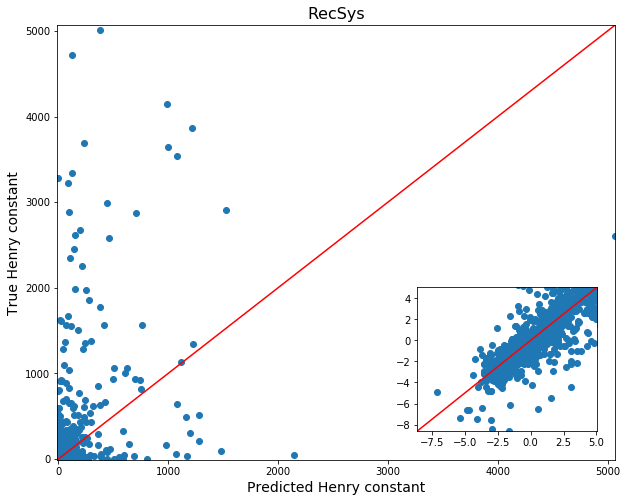

In [179]:
def parity_plot_real(actual, prediction, title):
    fig, ax = plt.subplots(figsize=(10,8))
    
    prediction = prediction.flatten()
    actual = actual.values.flatten()
    mask = ~np.isnan(actual)
    
    ax.scatter(np.exp(prediction[mask]), np.exp(actual[mask]))
    #ax.hexbin(np.exp(prediction[mask]), np.exp(actual[mask]))
    lim = [np.min([np.min(actual[mask]), np.min(np.exp(prediction[mask]))]), np.max([np.max(actual[mask]), np.max(np.exp(prediction[mask]))])]

    ax.plot(lim, lim, c='r')
    ax.set_xlabel('Predicted Henry constant', fontsize=14)
    ax.set_ylabel('True Henry constant', fontsize=14)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    
    ax2 = fig.add_axes([0.625, 0.175, 0.25, 0.25])
    ax2.scatter(prediction[mask], actual[mask])
    ax2.set_xlim([lim[0], lim[1]/1000])
    ax2.set_ylim([lim[0], lim[1]/1000])
    ax2.plot(lim, lim, c='r')
    ax.set_title(title, fontsize=16)
    plt.show()
    
parity_plot_real(log_henry_df, parity_pred, 'RecSys')

# Trashbin

In [ ]:
def predict_v3(x, y, mu):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + (x.T).dot(y)

In [ ]:
def predict_all_v3(U, V, mu):
    predictions = np.zeros((U.shape[0], V.shape[1]))
    for u in range(U.shape[0]):
        for i in range(V.shape[1]):
            predictions[u, i] = predict_v3(U[u,:], V[:,i], mu)
    return predictions

In [ ]:
def WNMF(henry_matrix, r, threshold, convergence=1e-5, maxiter=100000, verbose=True):
    n_iter = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    n_convergence = 0
    n, m = henry_matrix.shape
    
    W = ~np.isnan(henry_matrix)
    U = np.random.rand(n, r)
    V = np.random.rand(r, m)
    WA = np.multiply(W, henry_matrix)
    WA[np.isnan(WA)] = 0.0

    print('U shape: {}\tV shape: {}'.format(U.shape, V.shape))
    while train_error > threshold:
        
        for j in range(r):
            # Move WUV #1 here?
            WUV = np.multiply(W, np.matmul(U,V))
            for i in range(n):
                #WUV = np.multiply(W, np.matmul(U,V))
                U[i,j] = U[i,j] * (np.matmul(WA, np.transpose(V)))[i,j] / (np.matmul(WUV, np.transpose(V)))[i,j]
            # Move WUV #2 here?
            WUV = np.multiply(W, np.matmul(U,V))
            for i in range(m):
                #WUV = np.multiply(W, np.matmul(U,V))
                V[j,i] = V[j,i] * (np.matmul(np.transpose(U), WA))[j,i] / (np.matmul(np.transpose(U), WUV))[j,i] 
            
            if any(np.isnan(U.flatten())):
                raise Exception('''nan's in U''')
            if any(np.isnan(V.flatten())):
                raise Exception('''nan's in V''')
        
        pred = predict_all_v3(U, V, 0.0)[W].flatten()
        actual = henry_matrix[W].flatten()
        
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n_iter % 1000 == 0:
            print('Train Error on iteration {}: {}\n-------------'.format(n_iter, train_error))
            
        if error_diff < convergence:
            n_convergence += 1
            if n_convergence > 999:
                print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n_iter))
                print('Train error: {}'.format(train_error))
                break
        else:
            n_convergence = 0
        n_iter += 1
        if n_iter > maxiter:
            print('Maximum number of iterations reached.')
            break
    
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Train Loss')
    plt.grid('on')
    plt.tight_layout()
    plt.show()
    
    return U, V
mu = np.nanmean(henry_df.values)
norm_factors = np.nanmean(henry_df.values, axis=0)

U2, V2 = WNMF(henry_df.values/norm_factors, 20, 1e-5)

In [ ]:
h = np.matmul(U2,V2) * norm_factors
#i = random.choice(np.arange(henry_df.shape[0]))
#j = random.choice(np.arange(henry_df.shape[1]))
_i,_j = np.where(np.isnan(henry_df.values))
for _ in range(10):
    idx = random.choice(np.arange(len(_i)))
    i = _i[idx]
    j = _j[idx]
    print('Adsorption of {} in {}'.format(key_to_gas[henry_df.columns[j].split('_')[0]], key_to_material[henry_df.index[i]]))
    print('Prediction: {:.3f}'.format(h[i,j]))
    print('Actual value: {:.3f}\n'.format(henry_df.values[i,j]))

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
n = 8
ax.scatter(U2[:n, 0], U2[:n, 1], color='red', marker='x')
ax.scatter(V2[0,:n], V2[1,:n], color='blue', marker='o')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')

for i in range(n):
    ax.text(U2[i,0], U2[i,1], key_to_gas[henry_df.columns[i].split('_')[0]])
    ax.text(V2[0,i], V2[1,i], key_to_material[henry_df.index[i]])
plt.show()

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1, color='k')

plt.imshow(henry_df.values[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(henry_df.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(henry_df.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(h[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(h.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(h.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,8))
axs[0].hist(henry_df.values[~np.isnan(henry_df)].flatten(), bins=50)
axs[0].set_xlabel('Actual Henry constant [mmol/(g-bar)]')
axs[0].set_ylabel('Frequency')

axs[1].hist(h.flatten(), bins=50)
axs[1].set_xlabel('Predicted Henry constant [mmol/(g-bar)]')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
max_ind = np.unravel_index(np.argmax(h, axis=None), h.shape)

gas = key_to_gas[henry_df.columns[max_ind[1]].split('_')[0]]
material = key_to_material[henry_df.index[max_ind[0]]]
print('Biggest prediction is {:.2f} mmol/(g-bar)\nGas: {}, Material: {}'.format(h[max_ind], gas, material))
